In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from cort.core.corpora import Corpus
import os
from docopt import docopt
import sys
import re
from collections import defaultdict
from utils import map_values
import codecs


def read_dataset(inp_dir):
    mentions, tokens, names = defaultdict(list), defaultdict(list), defaultdict(list)
    for fname in os.listdir(inp_dir):
        if fname.endswith('_gold_conll'):
            genre = infer_genre(fname)
            path = os.path.join(inp_dir, fname)
            try:
                with codecs.open(path, 'r', 'utf-8') as f:
                    corpus = Corpus.from_file('', f)
            except KeyError:
                # https://github.com/dmcc/PyStanfordDependencies/issues/24
                sys.stderr.write("Ignored due to parsing error: %s\n" %path)
            for doc in corpus:
                if not doc.annotated_mentions:
                    sys.stderr.write("Document doesn't contain any mention: %s\n" %doc.identifier)
                else:
                    my_mentions, my_tokens, my_names = read_document(doc)
                    mentions[genre].extend(my_mentions)
                    tokens[genre].extend(my_tokens)
                    names[genre].extend(my_names)
    mentions['all'] = [n for list_ in mentions.values() for n in list_]
    tokens['all'] = [n for list_ in tokens.values() for n in list_]
    names['all'] = [n for list_ in names.values() for n in list_]
    return mentions, tokens, names


def infer_genre(fname):
    return re.match(r'(\w{2})_', fname).group(1)


def read_document(doc):
    mentions = [m for m in doc.annotated_mentions]
    tokens = [doc.tokens[i]
              for m in mentions
              for i in range(m.span.begin, m.span.end+1)]
    names = [' '.join(doc.tokens[i] 
                       for i in range(m.span.begin, m.span.end+1)
                       if doc.pos[i] in ['NNP', 'NNPS'])
              for m in mentions]
    names = [n for n in names if n != '']
    return mentions, tokens, names

In [3]:
inp_dir = '../data/conll-2012-flat'
_, train_tokens, train_names = read_dataset(os.path.join(inp_dir, 'train'))

Document doesn't contain any mention: (bn/voa/00/voa_0043); part 000
Document doesn't contain any mention: (nw/wsj/10/wsj_1088); part 000
Document doesn't contain any mention: (nw/wsj/13/wsj_1384); part 000
Document doesn't contain any mention: (bc/cnn/00/cnn_0001); part 009
Document doesn't contain any mention: (nw/xinhua/02/chtb_0205); part 000
Ignored due to parsing error: ../data/conll-2012-flat/train/tc_ch_0005.v4_gold_conll
Document doesn't contain any mention: (bn/voa/00/voa_0017); part 000
Document doesn't contain any mention: (bn/abc/00/abc_0024); part 000
Document doesn't contain any mention: (bn/abc/00/abc_0054); part 000
Document doesn't contain any mention: (nw/xinhua/01/chtb_0175); part 000
Document doesn't contain any mention: (nw/wsj/13/wsj_1342); part 000
Document doesn't contain any mention: (nw/wsj/14/wsj_1408); part 000
Document doesn't contain any mention: (bn/pri/00/pri_0097); part 000
Document doesn't contain any mention: (bn/voa/00/voa_0065); part 000
Document d

In [4]:
dev_mentions, dev_tokens, dev_names = read_dataset(os.path.join(inp_dir, 'dev'))

Document doesn't contain any mention: (bn/cnn/02/cnn_0240); part 000


In [5]:
num_dev_mentions = map_values(dev_mentions, len)

In [6]:
num_dev_mentions

{'bc': 3393,
 'bn': 2830,
 'pt': 3082,
 'nw': 4987,
 'mz': 1402,
 'wb': 1792,
 'tc': 1669,
 'all': 19155}

In [7]:
import numpy as np
import pandas as pd

def measure_coverage(train, dev, num_dev_mentions, type_):
    data = []
    unique_train = map_values(train, set)
    unique_dev = map_values(dev, set)
    for genre in train:
        num_covered = sum(1 for n in dev[genre] if n in unique_train[genre])
        num_unique_covered = len(unique_dev.get(genre, set())
                                      .intersection(unique_train[genre]))
        data.append({
            'type': type_,
            'genre': genre,
            'num_train': len(train[genre]),
            'num_dev': len(dev[genre]),
            'num_unique_train': len(unique_train[genre]),
            'num_unique_dev': len(unique_dev.get(genre, set())),
            'num_covered': num_covered,
            'num_unique_covered': num_unique_covered,
            'proportion_covered': np.float64(num_covered) / len(dev[genre]),
            'proportion_unique_covered': np.float64(num_unique_covered) / len(unique_dev[genre]),
            'num_dev_mentions': num_dev_mentions[genre]
        })
    return data

# Compare coverage of names and common tokens

In [8]:
data = (measure_coverage(train_tokens, dev_tokens, num_dev_mentions, 'tokens') +
        measure_coverage(train_names, dev_names, num_dev_mentions, 'names'))
df = pd.DataFrame(data)

In [9]:
df

,genre,num_covered,num_dev,num_dev_mentions,num_train,num_unique_covered,num_unique_dev,num_unique_train,proportion_covered,proportion_unique_covered,type
0,pt,5199,5304,3082,72138,523,586,2233,0.980204,0.892491,tokens
1,nw,14082,15736,4987,108694,2247,3167,11195,0.894891,0.709504,tokens
2,bn,6446,7151,2830,57748,1179,1610,6391,0.901412,0.732298,tokens
3,mz,2871,3547,1402,33878,527,860,4453,0.809416,0.612791,tokens
4,bc,5585,7147,3393,34897,777,1401,3716,0.781447,0.554604,tokens
5,tc,1902,2168,1669,15298,200,353,1669,0.877306,0.566572,tokens
6,wb,3511,4344,1792,29759,603,1123,4502,0.808241,0.536955,tokens
7,all,42303,45397,19155,352412,4576,6185,19845,0.931846,0.739854,tokens
8,pt,583,612,3082,9635,66,83,642,0.952614,0.795181,names
9,nw,1150,2268,4987,15780,244,930,5232,0.507055,0.262366,names


In [26]:
readable_genres = {
    'all': 'all genres',
    'bc': 'broadcast conv.',
    'bn': 'broadcast news',
    'mz': 'magazine',
    'nw': 'newswire',
    'pt': 'bible',
    'tc': 'telephone',
    'wb': 'websites'
}

def format_results(df):
    df['readable_genres'] = df['genre'].apply(readable_genres.__getitem__)
    return (df[['proportion_covered', 'readable_genres', 'num_dev_mentions', 'type']]
               .rename(columns={'proportion_covered': 'coverage', 'readable_genres': 'genre'})
               .sort_values('num_dev_mentions', ascending=False))

In [28]:
df_formatted = format_results(df)

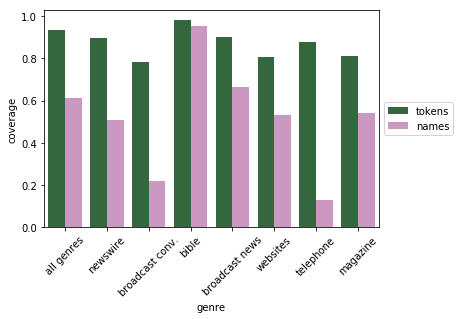

In [29]:
sns.set_palette('cubehelix', n_colors=2)
plt.xticks(rotation=45)
ax = sns.barplot(x='genre', y='coverage', hue='type', data=df_formatted)
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [17]:
ax.get_figure().savefig('../output/genre_token_coverage.pdf')

# Plot coverage of names in dev and test sets

In [20]:
test_mentions, test_tokens, test_names = read_dataset(os.path.join(inp_dir, 'test-key'))

Document doesn't contain any mention: (bc/cnn/00/cnn_0008); part 008
Document doesn't contain any mention: (nw/wsj/23/wsj_2390); part 000


In [21]:
test_tokens.keys()

dict_keys(['pt', 'bn', 'nw', 'mz', 'bc', 'wb', 'tc', 'all'])

In [31]:
data2 = (measure_coverage(train_names, dev_names, num_dev_mentions, 'dev') +
         measure_coverage(train_names, test_names, num_dev_mentions, 'test'))
df2 = pd.DataFrame(data2)
df_formatted2 = format_results(df2)

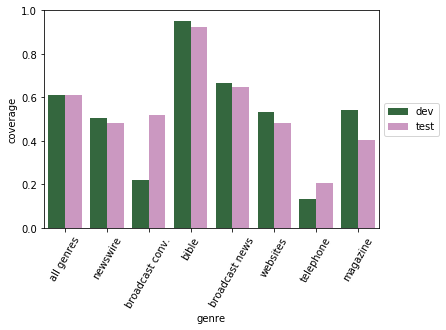

In [33]:
sns.set_palette('cubehelix', n_colors=2)
plt.xticks(rotation=60)
ax2 = sns.barplot(x='genre', y='coverage', hue='type', data=df_formatted2)
_ = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [34]:
ax2.get_figure().savefig('../output/genre_name_coverage.pdf')